# Graph abstraction using PAGA


In [ ]:
import os
from re import search
from dfply import *
import scvelo as scv

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Load settings

In [ ]:
if search("ricard", os.uname()[1]):
    exec(open('/Users/ricard/gastrulation10x/settings.py').read())
    exec(open('/Users/ricard/gastrulation10x/utils.py').read())
elif search("ebi", os.uname()[1]):
    exec(open('/homes/ricard/gastrulation10x/settings.py').read())
    exec(open('/homes/ricard/gastrulation10x/utils.py').read())
else:
    exit("Computer not recognised")

In [ ]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

## Define I/O

In [ ]:
io["outdir"] = io["basedir"] + "/results/PAGA"
io["outdir"]

## Define options 

In [ ]:
# %%capture
# sc.settings.verbosity = 3
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(9, 7), facecolor='white')

In [ ]:
opts["stages"] = [
	"E6.5",
	"E6.75",
	"E7.0",
	"E7.25",
	"E7.5",
	"E7.75",
	"E8.0",
	"E8.25",
	"E8.5",
	"mixed_gastrulation"
]

opts["celltypes"] = [
   "Epiblast",
   "Primitive_Streak",
   "Caudal_epiblast",
   "PGC",
   "Anterior_Primitive_Streak",
   "Notochord",
   "Def._endoderm",
   "Gut",
   "Nascent_mesoderm",
   "Mixed_mesoderm",
   "Intermediate_mesoderm",
   "Caudal_Mesoderm",
   "Paraxial_mesoderm",
   "Somitic_mesoderm",
   "Pharyngeal_mesoderm",
   "Cardiomyocytes",
   "Allantois",
   "ExE_mesoderm",
   "Mesenchyme",
   "Haematoendothelial_progenitors",
   "Endothelium",
   "Blood_progenitors_1",
   "Blood_progenitors_2",
   "Erythroid1",
   "Erythroid2",
   "Erythroid3"
   "NMP",
   "Rostral_neurectoderm",
   "Caudal_neurectoderm",
   "Neural_crest",
   "Forebrain_Midbrain_Hindbrain",
   "Spinal_cord",
   "Surface_ectoderm"
   "Visceral_endoderm",
   "ExE_endoderm",
   "ExE_ectoderm",
   "Parietal_endoderm"
]

## Load cell metadata

In [ ]:
metadata = (pd.read_table(io["metadata"]) >>
    mask(X.doublet==False, X.stripped==False) >>
    mask(X["stage"].isin(opts["stages"]), X["celltype"].isin(opts["celltypes"]))
)
metadata.shape

In [ ]:
metadata.head()

# Load anndata object

In [ ]:
adata = load_adata(
    adata_file = io["anndata"], 
    metadata_file = io["metadata"],
    cells = metadata.cell.values, 
    normalise = True, 
    filter_lowly_expressed_genes = False,
    set_colors = False
)
adata

## Feature selection

In [ ]:
sc.pp.highly_variable_genes(adata, layer=None, n_top_genes=2500)

# Dimensionality reduction

## PCA

Run PCA

In [ ]:
# sc.tl.pca(adata, n_comps=25, svd_solver='arpack')

Plot PCA

In [ ]:
sc.pl.pca(adata, components=[1,2], color=["celltype","stage"], size=25, legend_loc=None)

## Batch effect correction

In [ ]:
sc.external.pp.harmony_integrate(adata, key="stage", basis='X_pca', adjusted_basis='X_pca_harmony')

Plot

In [ ]:
# sc.pl.pca(adata, components=[1,2], color=["celltype","stage"], size=25, legend_loc=None)
sc.pl.embedding(adata, basis="X_pca_harmony", color=["celltype","stage"], size=25, legend_loc=None)

## Diffusion map

In [ ]:
sc.tl.diffmap(adata, n_comps=15)

In [ ]:
sc.pl.diffmap(adata, color=["celltype","stage"], size=25, legend_loc=None)

## k-NN graph

Build kNN graph

In [ ]:
# sc.pp.neighbors(adata, n_neighbors=15, n_pcs=25)
# sc.pp.neighbors(adata, use_rep="X_pca_harmony", n_neighbors=15, n_pcs=25)
sc.pp.neighbors(adata, use_rep="X_diffmap", n_neighbors=15)

## UMAP

Run UMAP

In [ ]:
# sc.tl.umap(adata, min_dist=0.5, n_components=2)

Plot UMAP

In [ ]:
sc.pl.umap(adata, color=["celltype","stage"], size=25, legend_loc=None)

## PAGA

In [ ]:
sc.tl.paga(adata, groups="celltype")

In [ ]:
sc.pl.paga(adata, max_edge_width=1, node_size_power=1, edge_width_scale=0.3, fontsize=5, threshold=0.23)

In [ ]:
adata.obsp["connectivities"].shape
adata.uns["neighbors"]["connectivities"].shape
adata.uns['paga']['connectivities'].shape
adata.uns["neighbors"]["params"]

## Plotting graph abstraction

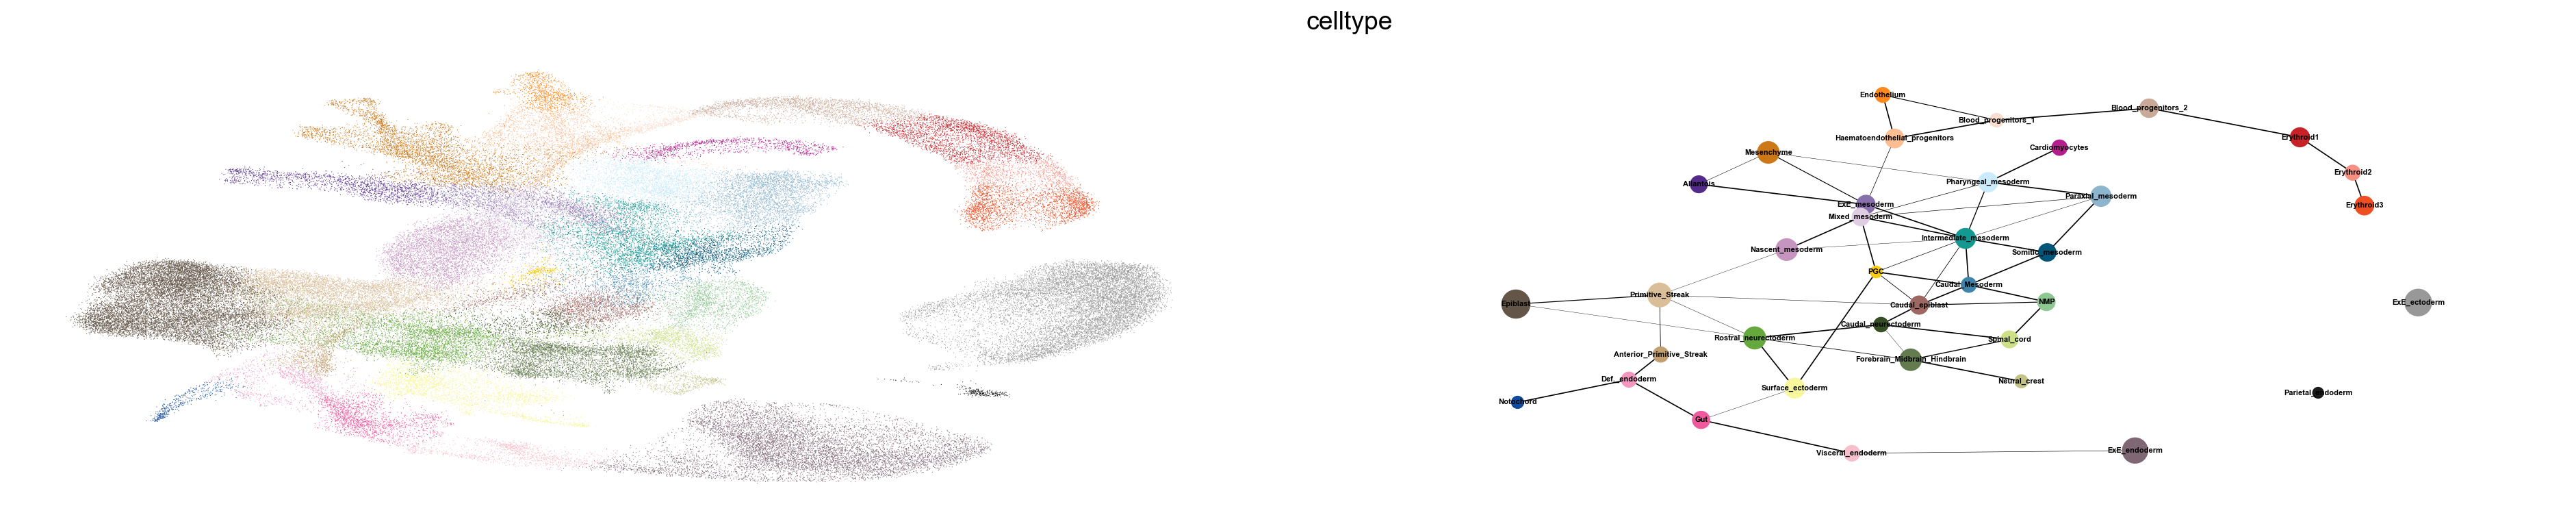

In [56]:
sc.pl.paga_compare(adata, basis='umap',legend_loc=None,
                   fontsize=5, threshold=0.23, color='celltype', edge_width_scale=0.1)

## Save

Save connectivities

In [ ]:
connectivities = adata.uns['paga']['connectivities'].todense()

pandas_to_save = pd.DataFrame(
    data = connectivities, 
    index = np.unique(adata.obs['celltype']), 
    columns = np.unique(adata.obs['celltype'])
).round(2)

pandas_to_save.to_csv(io["outdir"] + '/PAGA_connectivity.csv', sep=',')

Save graph coordinates

In [61]:
pandas_to_save = pd.DataFrame(
    data = adata.uns['paga']['pos'], 
    index = np.unique(adata.obs['celltype']), 
    columns = ["x","y"]
).round(2)

pandas_to_save.to_csv(io["outdir"] + '/PAGA_coordinates.csv', sep=',')

# Dendrograms (ignore)

In [ ]:
from scipy import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

In [ ]:
mat = adata.uns['paga']['connectivities'].todense()
labels = np.unique(adata.obs['celltype'])
matdist = 1-mat

np.fill_diagonal(matdist,0)

## Ward linkage

In [ ]:
thres = 1.6

In [ ]:
lk = linkage(matdist, "ward")
cutree = cluster.hierarchy.cut_tree(lk, height=thres)

den = dendrogram(lk, labels=labels, leaf_rotation=90)
plt.title('ward linkage')
plt.grid(True)

## Average linkage

In [ ]:
lk = linkage(matdist, "average")
cutree = cluster.hierarchy.cut_tree(lk, height=thres)

den = dendrogram(lk, labels=labels, leaf_rotation=90)
plt.title('average linkage')
plt.grid(True)

## Single linkage

In [ ]:
lk = linkage(matdist, "single")
cutree = cluster.hierarchy.cut_tree(lk, height=thres)

den = dendrogram(lk, labels=labels, leaf_rotation=90)
plt.title('single linkage')
plt.grid(True)

## Centroid linkage

In [ ]:
lk = linkage(matdist, "centroid")
# cutree = cluster.hierarchy.cut_tree(lk)

den = dendrogram(lk,labels=labels,leaf_rotation=90)
plt.title('centroid linkage')
plt.grid(True)